In [8]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [9]:
# Data download
# ==============================================================================
url = '/Users/sm_aswin21/Library/Mobile Documents/com~apple~CloudDocs/Code_Sus_Datathon/merged_dataset.csv'
data = pd.read_csv(url, sep=',')

In [11]:
print(data.columns)
print(data.head())

Index(['temp', 'visibility', 'solarenergy', 'cloudcover', 'datetime', 'precip',
       'solarradiation', 'dew', 'humidity', 'precipcover', 'windchill',
       'locations', 'Canonical', 'RowKey', 'INF_Label', 'INF_Value',
       'STA_Label', 'Sector_Neta', 'Zone_1', 'Zone_2', 'Zone_3'],
      dtype='object')
   temp  visibility  solarenergy  cloudcover       datetime  precip  \
0  24.0        14.8         24.4        29.4  1627862400000     0.0   
1  24.0        14.8         24.4        29.4  1627862400000     0.0   
2  24.0        14.8         24.4        29.4  1627862400000     0.0   
3  24.0        14.8         24.4        29.4  1627862400000     0.0   
4  25.8        14.6         24.7        33.7  1627948800000     0.0   

   solarradiation  dew  humidity  precipcover  ...              locations  \
0           452.7  3.8     27.87          0.0  ...  39.2210171,-3.6185337   
1           452.7  3.8     27.87          0.0  ...  39.2210171,-3.6185337   
2           452.7  3.8     27.87 

In [25]:
# Define a mapping of values to be replaced
replace_values = {1.0: 0, 1: 0, 'TRUE': 1}

# Apply the replacement for each column
data['Zone_1'] = data['Zone_1'].replace(replace_values)
data['Zone_2'] = data['Zone_2'].replace(replace_values)
data['Zone_3'] = data['Zone_3'].replace(replace_values)


In [21]:
# Define the columns to be dropped
columns_to_drop = ['INF_Label', 'STA_Label', 'locations', 'Canonical']

# Drop the specified columns
data = data.drop(columns_to_drop, axis=1)


In [22]:
print(data.columns)

Index(['temp', 'visibility', 'solarenergy', 'cloudcover', 'precip',
       'solarradiation', 'dew', 'humidity', 'precipcover', 'windchill',
       'RowKey', 'INF_Value', 'Sector_Neta', 'Zone_1', 'Zone_2', 'Zone_3'],
      dtype='object')


In [26]:
print(data.head())

   temp  visibility  solarenergy  cloudcover  precip  solarradiation  dew  \
0  24.0        14.8         24.4        29.4     0.0           452.7  3.8   
1  24.0        14.8         24.4        29.4     0.0           452.7  3.8   
2  24.0        14.8         24.4        29.4     0.0           452.7  3.8   
3  24.0        14.8         24.4        29.4     0.0           452.7  3.8   
4  25.8        14.6         24.7        33.7     0.0           456.5  7.7   

   humidity  precipcover  windchill                     RowKey      INF_Value  \
0     27.87          0.0        9.3  2021-08-01 22:00:00+00:00    4551.000000   
1     27.87          0.0        9.3  2021-08-01 22:00:00+00:00  256156.359375   
2     27.87          0.0        9.3  2021-08-01 22:00:00+00:00  950155.625000   
3     27.87          0.0        9.3  2021-08-01 22:00:00+00:00  396873.937500   
4     35.15          0.0        9.3  2021-08-02 22:00:00+00:00    4662.100098   

   Sector_Neta Zone_1 Zone_2  Zone_3  
0     22110

In [29]:
# Replace every 1 with 0 for each column
data['Zone_1'] = data['Zone_1'].replace([1, 1.0], 0)
data['Zone_2'] = data['Zone_2'].replace([1, 1.0], 0)
data['Zone_3'] = data['Zone_3'].replace([1, 1.0], 0)

# Replace 'True' with 1 for each column
data['Zone_1'] = data['Zone_1'].replace('True', 1)
data['Zone_2'] = data['Zone_2'].replace('True', 1)
data['Zone_3'] = data['Zone_3'].replace('True', 1)

data['Zone_1'].fillna(0, inplace=True)
data['Zone_2'].fillna(0, inplace=True)
data['Zone_3'].fillna(0, inplace=True)


# Display the Zone columns
print(data[['Zone_1', 'Zone_2', 'Zone_3']])


     Zone_1 Zone_2  Zone_3
0         0      0     0.0
1       1.0      0     0.0
2         0      0     0.0
3       1.0      1     0.0
4         0      0     0.0
...     ...    ...     ...
2167    1.0    1.0     0.0
2168      0      0     0.0
2169      0      0     0.0
2170    1.0      0     0.0
2171    1.0    1.0     0.0

[2172 rows x 3 columns]


In [52]:
# Create a copy of the data to keep the original intact
data_filtered = data.copy()

# Iterate over all numerical columns
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter data for each column without modifying the original dataset
    data_filtered = data_filtered[(data_filtered[column] >= lower_bound) & (data_filtered[column] <= upper_bound)]

# Now, data_filtered contains the data with outliers removed


In [54]:
print(data_filtered.head())

            temp  visibility  solarenergy  cloudcover  precip  solarradiation  \
RowKey                                                                          
2021-08-01  24.0        14.8         24.4        29.4     0.0           452.7   
2021-08-01  24.0        14.8         24.4        29.4     0.0           452.7   
2021-08-01  24.0        14.8         24.4        29.4     0.0           452.7   
2021-08-01  24.0        14.8         24.4        29.4     0.0           452.7   
2021-08-02  25.8        14.6         24.7        33.7     0.0           456.5   

            dew  humidity  precipcover  windchill      INF_Value  Sector_Neta  \
RowKey                                                                          
2021-08-01  3.8     27.87          0.0        9.3    4551.000000     22110000   
2021-08-01  3.8     27.87          0.0        9.3  256156.359375     22131000   
2021-08-01  3.8     27.87          0.0        9.3  950155.625000     22130000   
2021-08-01  3.8     27.87  

In [55]:
print(data_filtered.head())

            temp  visibility  solarenergy  cloudcover  precip  solarradiation  \
RowKey                                                                          
2021-08-01  24.0        14.8         24.4        29.4     0.0           452.7   
2021-08-01  24.0        14.8         24.4        29.4     0.0           452.7   
2021-08-01  24.0        14.8         24.4        29.4     0.0           452.7   
2021-08-01  24.0        14.8         24.4        29.4     0.0           452.7   
2021-08-02  25.8        14.6         24.7        33.7     0.0           456.5   

            dew  humidity  precipcover  windchill      INF_Value  Sector_Neta  \
RowKey                                                                          
2021-08-01  3.8     27.87          0.0        9.3    4551.000000     22110000   
2021-08-01  3.8     27.87          0.0        9.3  256156.359375     22131000   
2021-08-01  3.8     27.87          0.0        9.3  950155.625000     22130000   
2021-08-01  3.8     27.87  

In [56]:
print(data_filtered.columns)

Index(['temp', 'visibility', 'solarenergy', 'cloudcover', 'precip',
       'solarradiation', 'dew', 'humidity', 'precipcover', 'windchill',
       'INF_Value', 'Sector_Neta', 'Zone_1', 'Zone_2', 'Zone_3'],
      dtype='object')


In [60]:
mergeddata = data_filtered


In [74]:
import numpy as np

# Log transformation
mergeddata['INF_Value_log'] = np.log1p(data['INF_Value'])

ValueError: cannot reindex on an axis with duplicate labels

In [61]:
print(mergeddata.head())

            temp  visibility  solarenergy  cloudcover  precip  solarradiation  \
RowKey                                                                          
2021-08-01  24.0        14.8         24.4        29.4     0.0           452.7   
2021-08-01  24.0        14.8         24.4        29.4     0.0           452.7   
2021-08-01  24.0        14.8         24.4        29.4     0.0           452.7   
2021-08-01  24.0        14.8         24.4        29.4     0.0           452.7   
2021-08-02  25.8        14.6         24.7        33.7     0.0           456.5   

            dew  humidity  precipcover  windchill      INF_Value  Sector_Neta  \
RowKey                                                                          
2021-08-01  3.8     27.87          0.0        9.3    4551.000000     22110000   
2021-08-01  3.8     27.87          0.0        9.3  256156.359375     22131000   
2021-08-01  3.8     27.87          0.0        9.3  950155.625000     22130000   
2021-08-01  3.8     27.87  

In [70]:
print(mergeddata.shape)

(1546, 15)


In [68]:
inf_value_min = mergeddata['INF_Value'].min()
inf_value_max = mergeddata['INF_Value'].max()

print(f"Range of INF_Value: {inf_value_min} to {inf_value_max}")


Range of INF_Value: 0.0 to 1331925.75


In [76]:
mergeddata = mergeddata.reset_index(drop=True)
mergeddata['INF_Value_log'] = np.log1p(mergeddata['INF_Value'])


Train dates : 0 --- 1361  (n=1362)
Test dates  : 1362 --- 1545  (n=184)


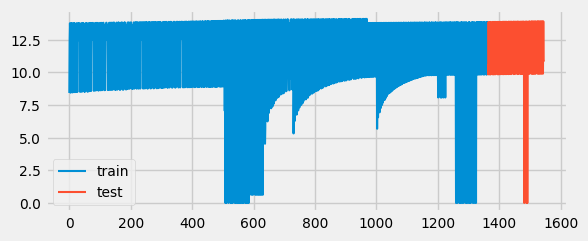

In [77]:
# Split data into train-test
# ==============================================================================
steps = 184  # Updated steps to 184
data_train = mergeddata[:-steps]  # Use mergeddata instead of data
data_test = mergeddata[-steps:]  # Use mergeddata instead of data

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['INF_Value_log'].plot(ax=ax, label='train')  # Updated 'y' to 'INF_Value_log'
data_test['INF_Value_log'].plot(ax=ax, label='test')  # Updated 'y' to 'INF_Value_log'
ax.legend();


In [78]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=data_train['INF_Value_log'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 1361] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-22 12:05:05 
Last fit date: 2023-10-22 12:05:06 
Skforecast version: 0.10.1 
Python version: 3.9.7 
Forecaster id: None 

In [79]:
# Predictions
# ==============================================================================
steps = 184
predictions = forecaster.predict(steps=steps)
predictions.head(5)

1362    10.617396
1363    10.222462
1364     9.576668
1365    13.457013
1366    11.059304
Name: pred, dtype: float64

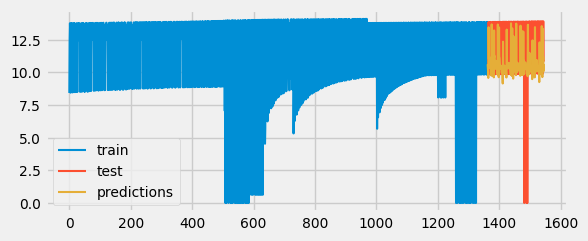

In [80]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['INF_Value_log'].plot(ax=ax, label='train')
data_test['INF_Value_log'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [81]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['INF_Value_log'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 5.642782632767367


In [82]:
# Hyperparameter grid search
# ==============================================================================
steps = 184
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['INF_Value_log'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False
               )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 8.344977659845428



In [103]:
results_grid


,lags,params,mean_squared_error,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",8.344978,3,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",8.517145,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",9.332078,3,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",9.472996,3,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",9.658513,5,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",9.789466,5,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",9.835709,5,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",9.967775,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",10.332836,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",10.467604,10,500


In [104]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['INF_Value_log'])

In [105]:
predictions = forecaster.predict(steps=steps)


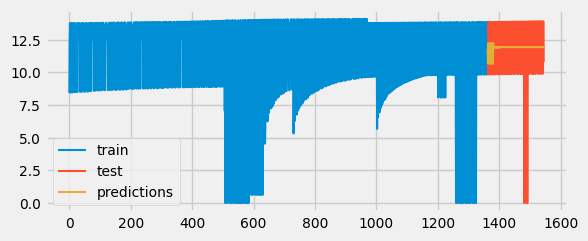

In [106]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['INF_Value_log'].plot(ax=ax, label='train')
data_test['INF_Value_log'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [107]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['INF_Value_log'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 4.914906952804489


In [108]:
# Backtesting
# ==============================================================================
steps = 184
n_backtesting = 184*3 # The last 9 years are separated for the backtest

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = data_train['INF_Value_log'],
                                    initial_train_size = len(data_train) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    metric             = 'mean_squared_error',
                                    refit              = True,
                                    verbose            = True,
                                    show_progress      = True
                                )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 810
Number of observations used for backtesting: 552
    Number of folds: 3
    Number of steps per fold: 184
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   0 -- 809  (n=810)
    Validation: 810 -- 993  (n=184)
Fold: 1
    Training:   0 -- 993  (n=994)
    Validation: 994 -- 1177  (n=184)
Fold: 2
    Training:   0 -- 1177  (n=1178)
    Validation: 1178 -- 1361  (n=184)



  0%|          | 0/3 [00:00<?, ?it/s]

Backtest error: 8.4004083349818


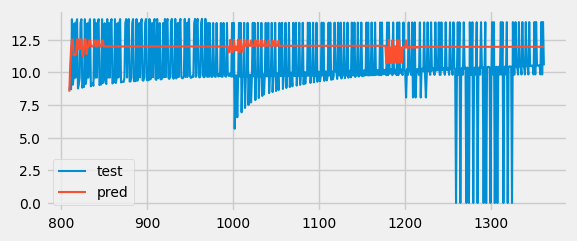

In [109]:
# Plot backtest predictions vs real values
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train.loc[predictions_backtest.index, 'INF_Value_log'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();


In [110]:
forecaster.get_feature_importances()


,feature,importance
0,lag_1,0.291394
1,lag_2,0.018616
2,lag_3,0.003848
3,lag_4,0.020199
4,lag_5,0.078232
5,lag_6,0.009007
6,lag_7,0.033498
7,lag_8,0.029944
8,lag_9,0.005146
9,lag_10,0.007956


In [111]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=data_train['INF_Value_log'], exog=data_train['temp'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: temp 
Training range: [0, 1361] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-22 12:45:16 
Last fit date: 2023-10-22 12:45:17 
Skforecast version: 0.10.1 
Python version: 3.9.7 
Forecaster id: None 

In [112]:
predictions = forecaster.predict(steps=steps, exog=data_test['temp'])


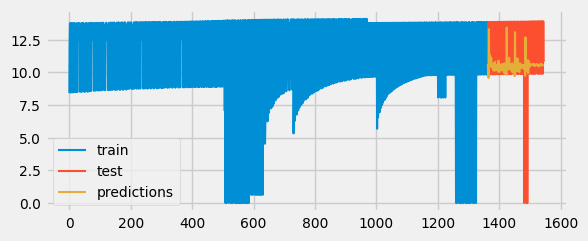

In [113]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['INF_Value_log'].plot(ax=ax, label='train')
data_test['INF_Value_log'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [114]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['INF_Value_log'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 4.77365743512315


In [121]:
# Hyperparameter Grid search
# ==============================================================================
steps = 184
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

lags_grid = [5, 12, 20]

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['INF_Value_log'],
                    exog        = data_train['temp'],
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    steps       = steps,
                    refit       = False,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = False
               )

Number of models compared: 27.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 8.344954113511973



In [125]:
results_grid.head()

,lags,params,mean_squared_error,max_depth,n_estimators
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",8.344954,3,500
18,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 50}",8.489846,3,50
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",8.516966,3,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 50}",9.304368,3,50
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 500}",9.317760,3,500


In [138]:
print(data_train.head())

   temp  visibility  solarenergy  cloudcover  precip  solarradiation  dew  \
0  24.0        14.8         24.4        29.4     0.0           452.7  3.8   
1  24.0        14.8         24.4        29.4     0.0           452.7  3.8   
2  24.0        14.8         24.4        29.4     0.0           452.7  3.8   
3  24.0        14.8         24.4        29.4     0.0           452.7  3.8   
4  25.8        14.6         24.7        33.7     0.0           456.5  7.7   

   humidity  precipcover  windchill      INF_Value  Sector_Neta Zone_1 Zone_2  \
0     27.87          0.0        9.3    4551.000000     22110000      0      0   
1     27.87          0.0        9.3  256156.359375     22131000    1.0      0   
2     27.87          0.0        9.3  950155.625000     22130000      0      0   
3     27.87          0.0        9.3  396873.937500     22132100    1.0      1   
4     35.15          0.0        9.3    4662.100098     22110000      0      0   

   Zone_3  INF_Value_log  
0     0.0       8.42332

In [132]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['INF_Value_log'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 4.77365743512315


In [140]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 184,
                lags          = 8
             )

forecaster

ForecasterAutoregDirect 
Regressor: Lasso(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Window size: 8 
Maximum steps predicted: 184 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': 123, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-22 14:34:37 
Last fit date: None 
Skforecast version: 0.10.1 
Python version: 3.9.7 
Forecaster id: None 

In [142]:
# Hyperparameter Grid search
# ==============================================================================
from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

forecaster = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 184,
                lags          = 8 # This value will be replaced in the grid search
             )

param_grid = {'alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = data_train['INF_Value'],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = 184,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    fixed_train_size   = False,
                    return_best        = True,
                    n_jobs             = 'auto',
                    verbose            = False
                )

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 0.021544346900318846}
  Backtesting metric: 269711825930.21945



In [143]:
results_grid.head()


,lags,params,mean_squared_error,alpha
3,"[1, 2, 3, 4, 5]",{'alpha': 0.021544346900318846},2.697118e+11,0.021544
2,"[1, 2, 3, 4, 5]",{'alpha': 0.0016681005372000592},2.724620e+11,0.001668
1,"[1, 2, 3, 4, 5]",{'alpha': 0.0001291549665014884},2.727321e+11,0.000129
0,"[1, 2, 3, 4, 5]",{'alpha': 1e-05},2.727574e+11,0.000010
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.021544346900318846},2.733679e+11,0.021544


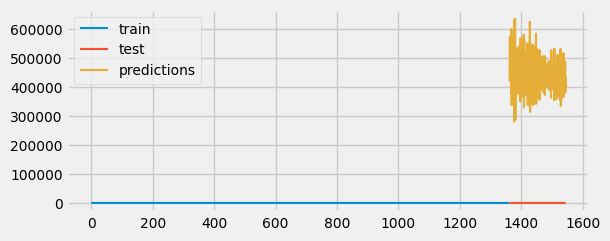

In [144]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['INF_Value_log'].plot(ax=ax, label='train')
data_test['INF_Value_log'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [146]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 15
             )

forecaster.fit(y=data_train["INF_Value_log"])

# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [1, 99],
                    n_boot   = 500
              )

predictions.head(5)

,pred,lower_bound,upper_bound
1362,11.016920,1.944800,16.152679
1363,11.105539,3.483665,16.971505
1364,11.008280,3.208690,16.118813
1365,11.484539,2.810827,17.473263
1366,11.059375,2.858733,16.361435


Test error (mse): 4.311406860942245


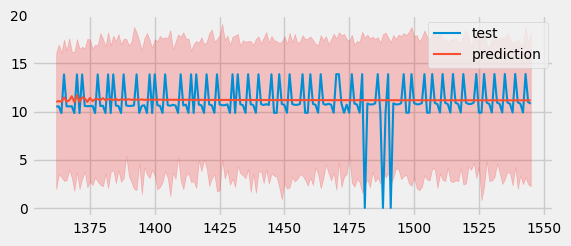

In [147]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['INF_Value_log'],
                y_pred = predictions.iloc[:, 0]
            )

print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_test['INF_Value_log'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='prediction')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

In [156]:
print(data_train.columns)


Index(['temp', 'visibility', 'solarenergy', 'cloudcover', 'precip',
       'solarradiation', 'dew', 'humidity', 'precipcover', 'windchill',
       'INF_Value', 'Sector_Neta', 'Zone_1', 'Zone_2', 'Zone_3',
       'INF_Value_log'],
      dtype='object')


Information of backtesting process
----------------------------------
Number of observations used for initial training: 810
Number of observations used for backtesting: 552
    Number of folds: 3
    Number of steps per fold: 184
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   0 -- 809  (n=810)
    Validation: 810 -- 993  (n=184)
Fold: 1
    Training:   0 -- 993  (n=994)
    Validation: 994 -- 1177  (n=184)
Fold: 2
    Training:   0 -- 1177  (n=1178)
    Validation: 1178 -- 1361  (n=184)



  0%|          | 0/3 [00:00<?, ?it/s]

Test error (mse): 7.035806999243226


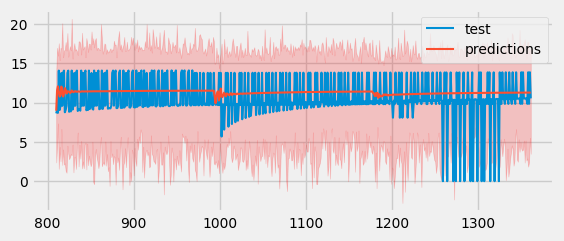

In [210]:
n_backtesting = 184*3
steps = 184
forecaster = ForecasterAutoreg(
                regressor = LinearRegression(),
                lags      = 15
             )

metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data_train['INF_Value_log'],
                            initial_train_size = len(data_train) - n_backtesting,
                            fixed_train_size   = False,
                            steps              = steps,
                            metric             = 'mean_squared_error',
                            refit              = True,
                            interval           = [1, 99],
                            n_boot             = 100,
                            n_jobs             = 'auto',
                            verbose            = True
                      )

print(f"Test error (mse): {metric}")  # Changed error_mse to metric

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
mergeddata.loc[predictions.index, 'INF_Value_log'].plot(ax=ax, label='test')  # Changed data to mergeddata and 'y' to 'INF_Value_log'
predictions['pred'].plot(ax=ax, label='predictions')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();


In [211]:
from sklearn.metrics import mean_absolute_error

def custom_metric(y_true, y_pred):
    '''
    Calculate the mean absolute error using only the predicted values of the last
    3 months of the year.
    '''
    # Ensure y_true.index is a DatetimeIndex
    if not isinstance(y_true.index, pd.DatetimeIndex):
        raise TypeError("y_true.index must be a DatetimeIndex")

    # Use the day method to get the day values
    mask = y_true.index.day.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric


In [212]:
def custom_metric(y_true, y_pred):
    '''
    Calculate the mean squared error using only the predicted values of the last
    3 months of the year.
    '''
    mask = y_true.index.day.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric

In [213]:
# Necessary Imports
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

# Define your custom metric:
def custom_metric(y_true, y_pred):
    # Replace with your custom logic
    error = y_true - y_pred
    return np.mean(error**2)

# Load your data:
# mergeddata = pd.read_csv("your_data_path.csv")

# I'm assuming you're using an autoregressive model, but replace with appropriate forecaster if not
# Train your forecaster:
# Example using Ridge regression from sklearn:
from sklearn.linear_model import Ridge
forecaster = ForecasterAutoreg(
    regressor=Ridge(),
    lags=12  # number of lags to use; adjust based on your needs
)

# Fit the forecaster on some initial data:
# You may need to adjust this based on how you've organized your data
# initial_data = mergeddata['INF_Value_log'].iloc[:-(n_backtesting)]
# forecaster.fit(y=initial_data)

steps = 184
n_backtesting = 184 * 3  # The last 9 years are separated for backtesting

metric, predictions_backtest = backtesting_forecaster(
    forecaster=forecaster,
    y=mergeddata['INF_Value_log'],
    initial_train_size=len(mergeddata) - n_backtesting,
    steps=steps,
    metric=custom_metric,
    verbose=True
)

print(f"Backtest error: {metric}")


Information of backtesting process
----------------------------------
Number of observations used for initial training: 994
Number of observations used for backtesting: 552
    Number of folds: 3
    Number of steps per fold: 184
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   0 -- 993  (n=994)
    Validation: 994 -- 1177  (n=184)
Fold: 1
    Training:   0 -- 993  (n=994)
    Validation: 1178 -- 1361  (n=184)
Fold: 2
    Training:   0 -- 993  (n=994)
    Validation: 1362 -- 1545  (n=184)



  0%|          | 0/3 [00:00<?, ?it/s]

Backtest error: 7.110019862751441


In [214]:
# Predicted interval coverage
# ==============================================================================
inside_interval = np.where(
                     (data_train.loc[predictions.index, 'INF_Value_log'] >= predictions['lower_bound']) & \
                     (data_train.loc[predictions.index, 'INF_Value_log'] <= predictions['upper_bound']),
                     True,
                     False
                   )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

Predicted interval coverage: 97.46 %


Custom Metric


In [215]:
# Custom metric 
# ==============================================================================
def custom_metric(y_true, y_pred):
    '''
    Calculate the mean squared error using only the predicted values of the last
    3 months of the year.
    '''
    mask = y_true.index.day.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric

In [216]:
initial_train_size = len(data_train) - n_backtesting


In [229]:
from sklearn.metrics import mean_absolute_error

def custom_metric(y_true, y_pred):
    
    # Convert the 'RowKey' to datetime (if not already)
    if not isinstance(y_true['RowKey'], pd.DatetimeIndex):
        y_true['RowKey'] = pd.to_datetime(y_true['RowKey'])
    
    mask = y_true['RowKey'].day.isin([10, 11, 12])
    
    # Use the mask to filter the actual values for computation
    metric = mean_absolute_error(y_true[mask]['value_column_name'], y_pred[mask]) # replace 'value_column_name' with the name of your value column
    
    return metric


In [234]:
# Create forecaster
forecaster = ForecasterAutoreg(RandomForestRegressor(random_state=123), lags=3)
forecaster.fit(y=mergeddata['INF_Value_log'])
forecaster.predict(steps=3)

1546     9.945173
1547     9.507695
1548    13.029161
Name: pred, dtype: float64

In [235]:
save_forecaster(forecaster, file_name='forecaster.py', verbose=False)


In [236]:
save_forecaster(forecaster, file_name='forecaster.py', verbose=False)


In [238]:
forecaster_loaded = load_forecaster('forecaster.py')


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 1545] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-22 15:30:59 
Last fit date: 2023-10-22 15:31:00 
Skforecast version: 0.10.1 
Python version: 3.9.7 
Forecaster id: None 



In [239]:
forecaster_loaded.predict(steps=3)


1546     9.945173
1547     9.507695
1548    13.029161
Name: pred, dtype: float64